# Final Project 

# Prediction of Cheese Class using Machine Learning(ML) Model

Created on Jul 11, 2020

Last updated on Jul 16, 2020

@author: Tresa Varghese

## Foreword

In this notebook, I will be showing the methods and results I found while creating a Machine Learning (ML) model for predicting the cheese class. The dataset used in this project is extracted from [Government of Canada's Open Government Portal](https://open.canada.ca/data/en/dataset/3c16cd48-3ac3-453f-8260-6f745181c83b). This work is done as a part of coursework for the Introduction to Machine Learning course at UBC. 

# Introduction

## Question(s) of interests

In this project, I ask the following question: **Given certain characteristics of a particular cheese, can it be classified as a `low fat` cheese or a `high fat` cheese.** This prediction can be useful in different ways, especially those who are keen on maintaining a healthy and balanced diet. Knowledge of the right cheese classification will help them with making appropriate decisions. 

It is clearly a **classification problem** as it aims to predict the class of a particular instance of cheese, given its various characteristics. The end result of this project can be useful in several other applications that helps people with meal preparation or healthy diet planning that meets the required daily calory intake. This is particulary useful for people withe high obesity, Blood Pressure or blood cholestrol level. In such applications, **correct identification of `high fat` cheese is more critical** than `low fat` ones. Hence I will be using `high fat` as positive label and `low fat` as negative label.

## Dataset description 

**cheese_data.csv**

It is a dataset about different types of Canadian cheeses found on the [Government of Canada's Open Government Portal](https://open.canada.ca/data/en/dataset/3c16cd48-3ac3-453f-8260-6f745181c83b). A modified version of the dataset is used with some data wrangling already done. The data follows an [Open Government Licence (Canada)](https://open.canada.ca/en/open-government-licence-canada).

# Exploratory Data Analysis

Let's begin with importing necessary packages and read in the data.

In [142]:
# import all the required libraries needed for this analysis
import pandas as pd
import numpy as np
import altair as alt
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.metrics import recall_score, classification_report, plot_confusion_matrix
from scipy.stats import lognorm, loguniform, randint

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Now, let's import the `cheese_data.csv` table. 

In [81]:
cheese_df = pd.read_csv("data/cheese_data.csv")

# examine table contents
cheese_df.head()

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat
2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat
3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat
4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat


First we will split our data into training and test set. Here as we don't have a huge amount of data, we set the test size as 20% and train size as 80%.

In [82]:
train_df, test_df = train_test_split(cheese_df, test_size=0.2, random_state=7)
print("Train dataset size: ", train_df.shape)
print("Test dataset size: ", test_df.shape)

Train dataset size:  (833, 13)
Test dataset size:  (209, 13)


Now we will do some exploratory analysis on the data to get some better understanding of the features and to gain useful insights about any interesting correlations among them. We begin by looking at some summary statistics and presence of null variables if any.

In [86]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 680 to 175
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CheeseId              833 non-null    int64  
 1   ManufacturerProvCode  833 non-null    object 
 2   ManufacturingTypeEn   833 non-null    object 
 3   MoisturePercent       822 non-null    float64
 4   FlavourEn             632 non-null    object 
 5   CharacteristicsEn     515 non-null    object 
 6   Organic               833 non-null    int64  
 7   CategoryTypeEn        816 non-null    object 
 8   MilkTypeEn            832 non-null    object 
 9   MilkTreatmentTypeEn   779 non-null    object 
 10  RindTypeEn            582 non-null    object 
 11  CheeseName            833 non-null    object 
 12  FatLevel              833 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 91.1+ KB


In [85]:
train_df.describe()

,CheeseId,MoisturePercent,Organic
count,833.000000,822.000000,833.000000
mean,1555.800720,47.146472,0.093637
std,444.214947,9.533438,0.291499
min,228.000000,12.000000,0.000000
25%,1279.000000,40.000000,0.000000
50%,1546.000000,46.000000,0.000000
75%,1889.000000,52.000000,0.000000
max,2388.000000,92.000000,1.000000


In [96]:
len(train_df['CheeseId'].unique())

833

In [97]:
train_df['Organic'].unique()

array([0, 1])

It is obvious that the columns `MoisturePercent`, `FlavourEn`, `CharacteristicsEn`, `CategoryTypeEn`, `MilkTypeEn`, `MilkTreatmentTypeEn`, and `RindTypeEn` all have null values. We need to do further analysis on these variables to identify which of these features are more useful in making our prediction.  

Among the columns described here, `CheeseId` is an id column with all unique values. Hence it is not useful in creating our model and we can delete it. `Organic` is a binary feature we will keep. It is already encoded and doesnt have any null values. Hence it doesnt need any transformation and can be directly used in our model.

Let's look at some of the other features to see whether there are any interesting trends.

In [92]:
plot1 = alt.Chart(train_df, width=70, height=300).mark_bar(opacity=0.7).encode(
    x=alt.X('FatLevel:N', title=""),
    y=alt.Y('count()'),
    color=alt.Color('FatLevel:N'),
    column=alt.Column('CategoryTypeEn:N', title='Category Type')
).properties(title="Comparison of cheese classes by category")

plot2 = alt.Chart(train_df, width=70, height=300).mark_bar(opacity=0.7).encode(
    x=alt.X('FatLevel:N', title=""),
    y=alt.Y('count()'),
    color=alt.Color('FatLevel:N'),
    column='ManufacturerProvCode:N'
).properties(title="Comparison of cheese classes by province")


plot3 = alt.Chart(train_df, width=70, height=300).mark_bar(opacity=0.7).encode(
    x=alt.X('FatLevel:N', title=""),
    y=alt.Y('count()'),
    color=alt.Color('FatLevel:N'),
    column='MilkTreatmentTypeEn:N'
).properties(title="Comparison of cheese classes by milk treatment type")

plot1

alt.Chart(...)

In [93]:
plot2

alt.Chart(...)

In [94]:
plot3

alt.Chart(...)

From the above plot we can see that, though there are more instances of lower fat cheese in the data set, the number of higher fat cheese manufactured seems to be higher in the province of BC. Also, in the category of firm cheese, the number of higher fat cheese dominates. If we look at milk treatment type, there are more number of lower fat cheese with treatment type Pasteurized. Hence we will definitely include these features in our model.

Let's also at the distribution of our target variable `FatLevel'.

In [95]:
plot4 = alt.Chart(train_df, width=500, height=300).mark_bar().encode(
    x='FatLevel', 
    y='count()'
).properties(title="Distribution of target class 'Fat Level'")

plot4

alt.Chart(...)

Here, the distribution of our target variable is not even. The number of `lower fat` cheese records are approximately double the number of `higher fat` cheese records. Hence we need to take necessary measures to account for this imbalance in data.


## Methods & Results

First, we drop all the features that we are not going to use in our prediction process. Then we need to separate the features and target. 

As we have a relatively small dataset and our target distribution is not balanced, we must do cross validation to create a model that best generalizes the data. As per the golden rule of machine learning, the test data needs to be separated and not be used in any stages of our training process. During cross validation, the data will be shuffled into training and test set in each cv fold. To have some truly unseen data to finally estimate the final model and find the true validation score, we keep the above `X_test` and `y_test` aside and create another split of our train_data to generate the necessary test data for our cross validation and hyperparameter tuning.


In [100]:
drop_columns = ['CheeseId', 'FlavourEn', 'CharacteristicsEn', 'RindTypeEn', 'CheeseName', 'FatLevel']

X_train_big = train_df.drop(columns=drop_columns)
X_test = test_df.drop(columns=drop_columns)

y_train_big = train_df['FatLevel']
y_test = test_df['FatLevel']

X_train, X_valid, y_train, y_valid = train_test_split(X_train_big, y_train_big, test_size=0.2, random_state=7)



First, we will build a baseline model using a dummy classifier. As our target data is not balanced, we use a stratified strategy to account for this imbalance. 

In [101]:
dummy_scores = pd.DataFrame(cross_validate(DummyClassifier(strategy='stratified'),
                              X_train, y_train, cv=5, return_train_score=True))

dummy_scores

,fit_time,score_time,test_score,train_score
0,0.001687,0.000864,0.604478,0.541353
1,0.001253,0.000605,0.593985,0.568480
2,0.001143,0.000581,0.488722,0.542214
3,0.001180,0.000571,0.533835,0.549719
4,0.001189,0.000569,0.503759,0.566604


Now, we will begin our process of building the model. First, we group the features based on its type to create the transformers and do the necessary preprocessing steps accordingly.

In [102]:
numeric_features = ['MoisturePercent']

binary_features = ['Organic']

ordinal_features = ['MilkTreatmentTypeEn']

categorical_features = ['ManufacturerProvCode', 'ManufacturingTypeEn', 'CategoryTypeEn', 'MilkTypeEn']

milk_treatment_order = ['Raw Milk', 'Thermised', 'Pasteurized']

We need to do imputation to deal with the missing values we identified earlier. For numeric features, the distribution is not very skewed. The mean and median values are almost same. Hence we use median as the strategy for the imputation. We also perform standard scaling as a best pratice. 

For categorical features, we use `most_frequent` as our strategy based on the examination of the values in the columns. Then we do one hot encoding to convert it into numerical type corresponding to each unique value in that feature. 

I have categorized the feature `MilkTreatmentTypeEn` as an ordinal feature as the different possible options `Raw Milk`, `Thermised` and `Pasteurized` have some order. Raw milk is untreated milk. Thermized treatment involves heating at low temperature for less time. Pasteurized involves more sophisticated treatment at higher temperature for longer duration.

Our binary feature `Organic` is already in encoded form. Hence we do not need any additional encoding. Also, it doesnt have any null values. Hence imputation is also not needed. Thus we just pass it through the column_transformer without any transformation as a passthrough feature.

In [105]:
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown="ignore")
)

ordinal_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(categories=[milk_treatment_order], dtype=int)
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    (ordinal_transformer, ordinal_features),
    remainder='passthrough'
)


Now that all the individual transformers to do necessary processing on the features based on their types and the column transformer to combine all these is built, we try to build different models to see how they perform.

We use the same column transformer and use models built on Support Vector classifer, Decision Tree and Random Forest with their default parameters. We create separate pipelines for each model and compare the predictions made by those pipelines. All the classifiers use `class_weight` attribute set to `balanced` to account for the imbalance in our target class. The cross-validation results are summarised into a dataframe to help with comparing the models.


In [106]:
# Build Support Vector Classifier pipeline

pipe_svc = make_pipeline(preprocessor, SVC(class_weight='balanced'))
scores_svc = pd.DataFrame(cross_validate(pipe_svc, X_train, y_train, return_train_score=True))
scores_svc

,fit_time,score_time,test_score,train_score
0,0.034616,0.013682,0.791045,0.828947
1,0.033921,0.013441,0.751880,0.844278
2,0.033787,0.013853,0.796992,0.818011
3,0.033378,0.013459,0.819549,0.823640
4,0.033717,0.013557,0.789474,0.804878


In [110]:
# Build Decision Tree Classifier pipeline

pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(class_weight='balanced'))
scores_dt = pd.DataFrame(cross_validate(pipe_dt, X_train, y_train, return_train_score=True))
scores_dt

,fit_time,score_time,test_score,train_score
0,0.028936,0.011608,0.776119,0.960526
1,0.023725,0.024558,0.804511,0.958724
2,0.024029,0.011344,0.842105,0.958724
3,0.027048,0.011431,0.864662,0.951220
4,0.024315,0.011520,0.827068,0.954972


In [111]:
# Build random forest Classifier pipeline

pipe_rand_forest = make_pipeline(preprocessor, RandomForestClassifier(class_weight='balanced'))
scores_rand_forest = pd.DataFrame(cross_validate(pipe_rand_forest, X_train, y_train, return_train_score=True))
scores_rand_forest

,fit_time,score_time,test_score,train_score
0,0.249496,0.025137,0.798507,0.960526
1,0.231985,0.025048,0.819549,0.958724
2,0.234509,0.025180,0.812030,0.958724
3,0.236189,0.025437,0.879699,0.951220
4,0.235682,0.025202,0.864662,0.954972


In [112]:
print("SVC mean test score : ", scores_svc['test_score'].mean())
print("Decision Tree mean test score : ", scores_dt['test_score'].mean())
print("Random Forest mean test score : ", scores_rand_forest['test_score'].mean())

SVC mean test score :  0.7897879025923016
Decision Tree mean test score :  0.8228930535293457
Random Forest mean test score :  0.8348894624621256


It appears that random forest classifier is performing better based on the test score. 

In cross-validation, we used the default metric of **accuracy** to evaluate the performance of our models. We now plot confusion matrix to see whether it is the right approach or whether we should consider some other measure for evaluating model accuracy. 

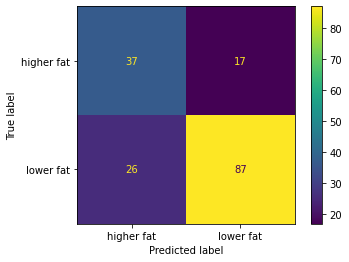

In [114]:
# confusion matrix for SVC

pipe_svc.fit(X_train, y_train)
plot_confusion_matrix(pipe_svc, X_valid, y_valid)

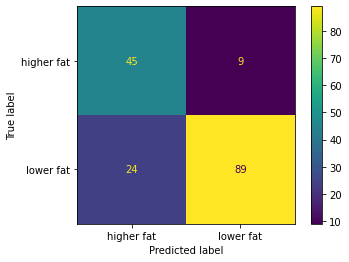

In [115]:
# confusion matrix for decision tree

pipe_dt.fit(X_train, y_train)
plot_confusion_matrix(pipe_dt, X_valid, y_valid)

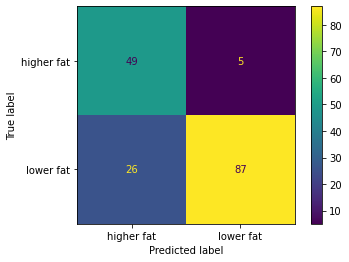

In [116]:
# confusion matrix for random forest

pipe_rand_forest.fit(X_train, y_train)
plot_confusion_matrix(pipe_rand_forest, X_valid, y_valid)

For the problem we are trying to address, correct classifiction of higher fat cheese is more critical. Hence **reducing the number of False Negative is our higher priority** and we are interested in optimizing our `recall` score. 

Based on the confusion matrices plotted above, decision tree and random forest appears to do well. With decision tree, FN is 9 and with random forest, FN is 5. We will also generate classification report on predictions made using these two models to get a more better understanding.

In [117]:
# classification report for decision tree

predicted_y_dt = pipe_dt.predict(X_valid)
print(classification_report(y_valid, predicted_y_dt, digits=3))

              precision    recall  f1-score   support

  higher fat      0.652     0.833     0.732        54
   lower fat      0.908     0.788     0.844       113

    accuracy                          0.802       167
   macro avg      0.780     0.810     0.788       167
weighted avg      0.825     0.802     0.807       167



In [118]:
# classification report for random forest

predicted_y_rand_forest = pipe_rand_forest.predict(X_valid)
print(classification_report(y_valid, predicted_y_rand_forest, digits=3))

              precision    recall  f1-score   support

  higher fat      0.653     0.907     0.760        54
   lower fat      0.946     0.770     0.849       113

    accuracy                          0.814       167
   macro avg      0.799     0.839     0.804       167
weighted avg      0.851     0.814     0.820       167



Again, random forest appears to provide better recall score when our focus is on higher fat data. So we fix the model as random forest and perform some hyper parameter tuning to increase the generalization performance.

First we populate the param_grid with the values we woule like to check and create our main pipeline. Here I use RandomizedSearchCV to do the necessary hyper parameter tuning. 

In [135]:
import scipy
from scipy.stats import randint

param_grid = {
    "randomforestclassifier__n_estimators": scipy.stats.randint(low=10, high=300),
    "randomforestclassifier__max_depth": scipy.stats.randint(low=2, high=20),
    "randomforestclassifier__min_samples_split": range(2, 50, 2)    
}

main_pipe = make_pipeline(preprocessor, RandomForestClassifier(class_weight='balanced'))

random_search = RandomizedSearchCV(main_pipe, param_grid, n_iter=10, cv=5, random_state=888, n_jobs=-1, verbose=1, return_train_score=True)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['MoisturePercent']),
                                                                              ('pipeline-2',
                                                         

In [136]:
pd.DataFrame(random_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.286508,0.004187,0.031850,0.000156,15,32,160,"{'randomforestclassifier__max_depth': 15, 'ran...",0.776119,0.796992,...,0.816878,0.029068,7,0.877820,0.881801,0.863039,0.863039,0.876173,0.872374,0.007839
1,0.341992,0.001083,0.036399,0.000082,9,30,198,"{'randomforestclassifier__max_depth': 9, 'rand...",0.783582,0.804511,...,0.822882,0.027503,5,0.885338,0.857411,0.857411,0.855535,0.876173,0.866373,0.012115
2,0.395306,0.001344,0.040441,0.000169,15,36,231,"{'randomforestclassifier__max_depth': 15, 'ran...",0.783582,0.796992,...,0.821378,0.028648,6,0.877820,0.864916,0.866792,0.853659,0.872420,0.867121,0.008109
3,0.294030,0.001858,0.029941,0.000993,14,2,131,"{'randomforestclassifier__max_depth': 14, 'ran...",0.805970,0.812030,...,0.839390,0.039421,1,0.960526,0.958724,0.956848,0.949343,0.953096,0.955708,0.004024
4,0.078352,0.000855,0.016258,0.000068,5,34,36,"{'randomforestclassifier__max_depth': 5, 'rand...",0.798507,0.759398,...,0.798799,0.029840,10,0.842105,0.833021,0.827392,0.829268,0.831144,0.832586,0.005116
5,0.245025,0.002438,0.029093,0.000074,16,42,139,"{'randomforestclassifier__max_depth': 16, 'ran...",0.791045,0.781955,...,0.816856,0.026843,8,0.868421,0.855535,0.849906,0.853659,0.848030,0.855110,0.007165
6,0.251521,0.003198,0.028135,0.000087,9,6,128,"{'randomforestclassifier__max_depth': 9, 'rand...",0.798507,0.796992,...,0.830378,0.029973,3,0.909774,0.919325,0.911820,0.893058,0.900563,0.906908,0.009150
7,0.247838,0.000587,0.029715,0.000120,5,26,146,"{'randomforestclassifier__max_depth': 5, 'rand...",0.805970,0.766917,...,0.816833,0.033050,9,0.836466,0.846154,0.833021,0.834897,0.831144,0.836336,0.005223
8,0.094578,0.000750,0.017085,0.000116,16,10,39,"{'randomforestclassifier__max_depth': 16, 'ran...",0.798507,0.789474,...,0.834889,0.041185,2,0.909774,0.900563,0.906191,0.893058,0.896811,0.901279,0.006072
9,0.115005,0.000644,0.018880,0.000130,12,22,55,"{'randomforestclassifier__max_depth': 12, 'ran...",0.791045,0.796992,...,0.825878,0.027896,4,0.885338,0.881801,0.879925,0.861163,0.868668,0.875379,0.009036


In [137]:
random_search.best_params_

{'randomforestclassifier__max_depth': 14,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 131}

In [138]:
random_search.best_score_

0.8393895185725508

In [139]:
# Training score

random_search.score(X_train, y_train)

0.9519519519519519

In [140]:
# Validation score

random_search.score(X_valid, y_valid)

0.8203592814371258

In [158]:
best_estimator = random_search.best_estimator_
best_estimator

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['MoisturePercent']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                  

Now that we have identified the best estimator, we use this estimator to find the true test score using our test data that we have set aside in the beginning. First, we train our original split of training data using the best estimator and then make predictions on the test data. 

In [168]:
best_estimator.score(X_test, y_test)

0.8277511961722488

We are getting a testing accuracy of 0.82


# Discussions

In this work, I have used the cheese dataset to create a machine learning model that can predict whether a particular sequence of features correspond to higher fat or lower fat cheese category. As we are more interested in correctly identifying the higher fat ones, we used it as our positive label. To reduce the number of False Negatives, we used recall as our evaluation metric to compare the different models.

# References

Not all the work in this notebook is original. Most of the code is referenced from course material for Introduction to Machine Learning by UBC. I take no credit for parts that are not mine.

## Resources used

* [Data Source](https://open.canada.ca/data/en/dataset/3c16cd48-3ac3-453f-8260-6f745181c83b)
    * This cheese dataset used in this work follows a Creative Common Attribution 4.0 International License.